# _Does Temperature Affect Covid-19 Spread?_
____

In [10]:
# Dependencies

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from scipy.stats import linregress

import requests
import json

import datetime

# Import api keys for weather and gmaps
from config import (weather_key, g_key)

# Import and access maps with API key
import gmaps
gmaps.configure(api_key = g_key)

#import time
#from us import states


## _Countrywise Covid-19 Data_

___

In [11]:
# Loading raw Covid-19 data for countries

raw_global_data = pd.read_csv("../Resources/Covid19_Global.csv")
raw_global_data.head(10)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,74,84,94,110,110,120,170,174,237,273
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,123,146,174,186,197,212,223,243,259,277
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,264,302,367,409,454,511,584,716,847,986
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,164,188,224,267,308,334,370,376,390,428
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,3,3,4,4,5,7,7,7,8,8
5,NaN,Antigua and Barbuda,17.0608,-61.7964,0,0,0,0,0,0,...,3,3,7,7,7,7,7,7,7,9
6,NaN,Argentina,-38.4161,-63.6167,0,0,0,0,0,0,...,387,387,502,589,690,745,820,1054,1054,1133
7,NaN,Armenia,40.0691,45.0382,0,0,0,0,0,0,...,249,265,290,329,407,424,482,532,571,663
8,Australian Capital Territory,Australia,-35.4735,149.0124,0,0,0,0,0,0,...,39,39,53,62,71,77,78,80,84,87
9,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,...,818,1029,1219,1405,1617,1791,2032,2032,2182,2298


In [12]:
# Extracting required columns 
Covid_global_data  = raw_global_data[["Country/Region",
                                      "Lat", "Long",
                             "1/22/20", "1/29/20","2/5/20","2/12/20",
                             "2/19/20", "2/26/20", "3/4/20", "3/11/20",
                             "3/18/20", "3/25/20", "4/2/20"
                                     ]]

# Renaming column names
Covid_global_data = Covid_global_data.rename(columns={"Country/Region": "Country", 
                                                      "Lat": "Latitude", 
                                                      "Long": "Longitude"})

# Sorting the data by latest case_count
Covid_global_data = Covid_global_data.sort_values("4/2/20", ascending = False)

# Dropping few countries
# (Ex:china as it almost reached peak count for this time frame)
Covid_global_data = Covid_global_data.drop([62,42,143])

# Resetting the index 
Covid_global_data.reset_index(inplace = True, drop = True)

# Selecting top 30 affected countries
Covid_global_data = Covid_global_data.iloc[:31,:]

Covid_global_data

,Country,Latitude,Longitude,1/22/20,1/29/20,2/5/20,2/12/20,2/19/20,2/26/20,3/4/20,3/11/20,3/18/20,3/25/20,4/2/20
0,US,37.0902,-95.7129,1,5,11,12,13,57,149,1281,7783,65778,243453
1,Italy,43.0000,12.0000,0,0,2,3,3,453,3089,12462,35713,74386,115242
2,Spain,40.0000,-4.0000,0,0,1,2,2,13,222,2277,13910,49515,112065
3,Germany,51.0000,9.0000,0,4,12,16,16,27,262,1908,12327,37323,84794
4,France,46.2276,2.2137,0,5,6,11,12,18,285,2281,9043,25233,59105
5,Iran,32.0000,53.0000,0,0,0,0,2,139,2922,9000,17361,27017,50468
6,United Kingdom,55.3781,-3.4360,0,0,2,9,9,13,85,456,2626,9529,33718
7,Switzerland,46.8182,8.2275,0,0,0,0,0,1,90,652,3028,10897,18827
8,Turkey,38.9637,35.2433,0,0,0,0,0,0,0,1,98,2433,18135
9,Belgium,50.8333,4.0000,0,0,1,1,1,1,23,314,1486,4937,15348


#### _Extracting temperatures for countries_

In [13]:
# Country_temperatures 

base_url = "http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID="

# Retrieving latitudes and longitudes

lats = Covid_global_data["Latitude"]
lngs = Covid_global_data["Longitude"]

lat_lngs = zip(lats, lngs)

# Create a list to store temperatures

temperatures = []

# Aquiring temperatures by making api calls

for lat_lng in lat_lngs:
    
    query_url = f'{base_url}{weather_key}&lat={lat_lng[0]}&lon={lat_lng[1]}'
    
    results = requests.get(query_url).json()
    
    country_temp = results["main"]["temp"]
    
    temperatures.append(country_temp)
    
# Add temperatures to "Temperature" column 

Covid_global_data["Temp(F)"] = temperatures

Covid_global_data.head()

,Country,Latitude,Longitude,1/22/20,1/29/20,2/5/20,2/12/20,2/19/20,2/26/20,3/4/20,3/11/20,3/18/20,3/25/20,4/2/20,Temp(F)
0,US,37.0902,-95.7129,1,5,11,12,13,57,149,1281,7783,65778,243453,84.54
1,Italy,43.0000,12.0000,0,0,2,3,3,453,3089,12462,35713,74386,115242,47.48
2,Spain,40.0000,-4.0000,0,0,1,2,2,13,222,2277,13910,49515,112065,57.02
3,Germany,51.0000,9.0000,0,4,12,16,16,27,262,1908,12327,37323,84794,53.96
4,France,46.2276,2.2137,0,5,6,11,12,18,285,2281,9043,25233,59105,50.25


#### _Extracting Population_density for Countries_

In [14]:
# Loading raw data for population 
Population_global_data = pd.read_csv("../Resources/Population_global_data.csv")

# Extracting required rows and columns from raw data
Population_global_data = Population_global_data.iloc[0:193, [1,4,7]] 

# Renaming Column names
Population_global_data = Population_global_data.rename(columns={"country": "Country",
                                                                "pop": "Population",
                                                                "density": "Pop_density"
                                                              
                                                               })

# Dropping duplicate values
Population_global_data = Population_global_data.drop_duplicates(subset = 'Country', keep='first')

# Resetting the index 
Population_global_data.reset_index(inplace = True, drop = True)

Population_global_data

,Country,Population,Pop_density
0,Afghanistan,"38,928,346",60.0
1,Albania,"2,877,797",105.0
2,Algeria,"43,851,044",18.0
3,Andorra,"77,265",164.0
4,Antigua and Barbuda,"97,929",223.0
...,...,...,...
170,Uzbekistan,"33,469,203",79.0
171,Venezuela,"28,435,940",32.0
172,Vietnam,"97,338,579",314.0
173,Zambia,"18,383,955",25.0


In [15]:
# Merge Covid global data and population global data

Covid_global_data = pd.merge(Covid_global_data, Population_global_data, 
                             on = "Country", how = 'left')

# Arrange the columns in the desired order

Covid_global_data = Covid_global_data[["Country", "Latitude", "Longitude",
                                       "Temp(F)", "Population", "Pop_density",
                             "1/22/20", "1/29/20","2/5/20","2/12/20",
                             "2/19/20", "2/26/20", "3/4/20", "3/11/20",
                             "3/18/20", "3/25/20", "4/2/20"
                                      ]]



Covid_global_data

,Country,Latitude,Longitude,Temp(F),Population,Pop_density,1/22/20,1/29/20,2/5/20,2/12/20,2/19/20,2/26/20,3/4/20,3/11/20,3/18/20,3/25/20,4/2/20
0,US,37.0902,-95.7129,84.54,"168,775",313.0,1,5,11,12,13,57,149,1281,7783,65778,243453
1,Italy,43.0000,12.0000,47.48,"60,461,826",206.0,0,0,2,3,3,453,3089,12462,35713,74386,115242
2,Spain,40.0000,-4.0000,57.02,"46,754,778",94.0,0,0,1,2,2,13,222,2277,13910,49515,112065
3,Germany,51.0000,9.0000,53.96,"83,783,942",240.0,0,4,12,16,16,27,262,1908,12327,37323,84794
4,France,46.2276,2.2137,50.25,"65,273,511",119.0,0,5,6,11,12,18,285,2281,9043,25233,59105
5,Iran,32.0000,53.0000,62.17,"83,992,949",52.0,0,0,0,0,2,139,2922,9000,17361,27017,50468
6,United Kingdom,55.3781,-3.4360,45.32,"67,886,011",281.0,0,0,2,9,9,13,85,456,2626,9529,33718
7,Switzerland,46.8182,8.2275,47.01,"8,654,622",219.0,0,0,0,0,0,1,90,652,3028,10897,18827
8,Turkey,38.9637,35.2433,44.60,"84,339,067",110.0,0,0,0,0,0,0,0,1,98,2433,18135
9,Belgium,50.8333,4.0000,56.35,"11,589,623",383.0,0,0,1,1,1,1,23,314,1486,4937,15348


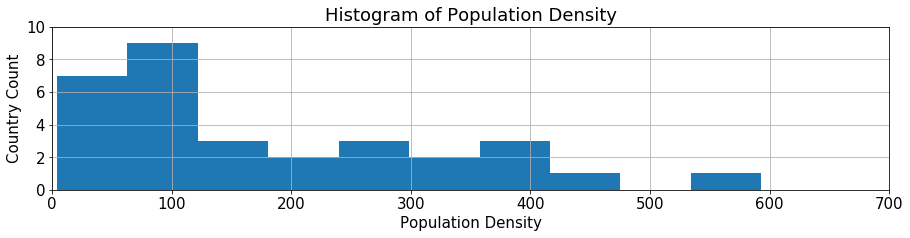

<Figure size 1080x216 with 0 Axes>

In [16]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15.0, 3.0]
plt.rcParams.update({'font.size': 15,})
#plt.hist('Covid_global_data.4/2/20', 'Covid_global_data.4/2/20')

plt.hist(Covid_global_data.Pop_density)

plt.xlabel('Population Density')
plt.ylabel('Country Count')
plt.title('Histogram of Population Density')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.xlim(0, 700)
plt.ylim(0, 10)
plt.grid(True)
#plt.align('right')
plt.show()

plt.savefig('../figures/Fig-0_Histogram')

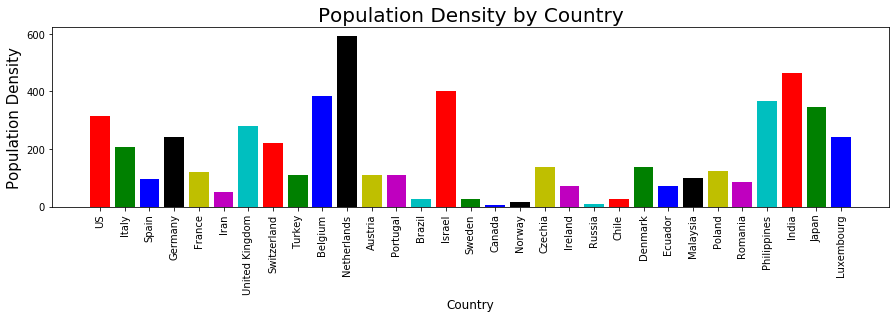

In [17]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15.0, 3.0]
plt.rcParams.update({'font.size': 22,})

plt.bar(Covid_global_data.Country, Covid_global_data.Pop_density, color = list('rgbkymc'))



plt.xticks(rotation=90,size=10)
plt.yticks(size=10)

#barlist=plt.bar([1,2,3,4], [1,2,3,4])
#barlist[0].set_color('r')
#barlist[1].set_color('b')

#color = list('rgbkymc')
#color=(0.133,0.545,0.133,1))

plt.title("Population Density by Country", size=20 )
plt.xlabel ('Country', size=12) 
plt.ylabel ('Population Density', size=15)

plt.gcf().subplots_adjust(bottom=0.05)


plt.savefig('figures/Fig-2_Country vs PopDensity')


plt.show()

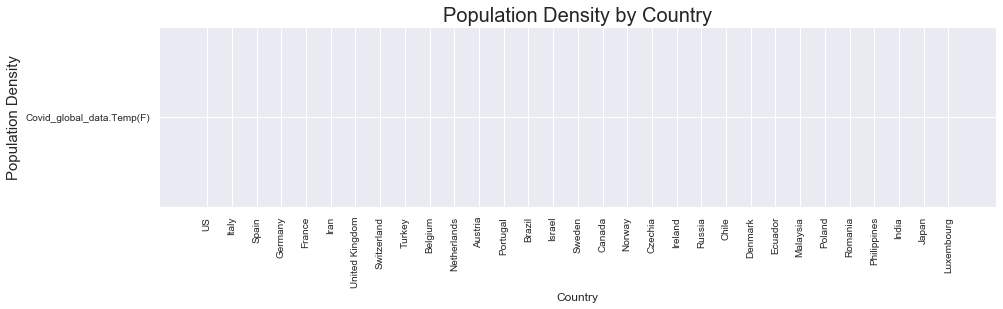

In [45]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15.0, 3.0]
plt.rcParams.update({'font.size': 22,})

plt.bar(Covid_global_data.Country, ['Covid_global_data.Temp(F)'], color = list('rgbkymc'))



plt.xticks(rotation=90,size=10)
plt.yticks(size=10)

#barlist=plt.bar([1,2,3,4], [1,2,3,4])
#barlist[0].set_color('r')
#barlist[1].set_color('b')

#color = list('rgbkymc')
#color=(0.133,0.545,0.133,1))

plt.title("Population Density by Country", size=20 )
plt.xlabel ('Country', size=12) 
plt.ylabel ('Population Density', size=15)

plt.gcf().subplots_adjust(bottom=0.05)


plt.savefig('../figures/Fig-3_Test3')


plt.show()

In [19]:
covid_pivot = Covid_global_data.copy()
covid_pivot = covid_pivot.drop(columns = ["Latitude", "Longitude","Temp(F)", "Population", "Pop_density"], axis=1)
covid_pivot = covid_pivot.set_index("Country")
covid_pivot.head()

,1/22/20,1/29/20,2/5/20,2/12/20,2/19/20,2/26/20,3/4/20,3/11/20,3/18/20,3/25/20,4/2/20
Country,,,,,,,,,,,
US,1,5,11,12,13,57,149,1281,7783,65778,243453
Italy,0,0,2,3,3,453,3089,12462,35713,74386,115242
Spain,0,0,1,2,2,13,222,2277,13910,49515,112065
Germany,0,4,12,16,16,27,262,1908,12327,37323,84794
France,0,5,6,11,12,18,285,2281,9043,25233,59105


In [20]:
covid_pivot.describe()

,1/22/20,1/29/20,2/5/20,2/12/20,2/19/20,2/26/20,3/4/20,3/11/20,3/18/20,3/25/20,4/2/20
count,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,0.096774,0.903226,2.483871,3.516129,5.580645,30.645161,250.516129,1105.838710,3747.709677,11274.806452,27655.322581
std,0.396219,2.150269,5.052201,6.742260,15.562292,88.750793,741.435539,2685.590017,7443.225793,19580.895375,50804.770030
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,94.000000,636.000000,2487.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,40.500000,244.500000,1320.000000,3274.500000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,23.000000,149.000000,790.000000,2433.000000,5568.000000
75%,0.000000,0.000000,2.000000,3.000000,3.000000,13.000000,87.500000,618.500000,2338.500000,7970.500000,18481.000000
max,2.000000,7.000000,22.000000,28.000000,84.000000,453.000000,3089.000000,12462.000000,35713.000000,74386.000000,243453.000000


In [47]:
#pivot data table to plot easier
covid_pivot = covid_pivot.T


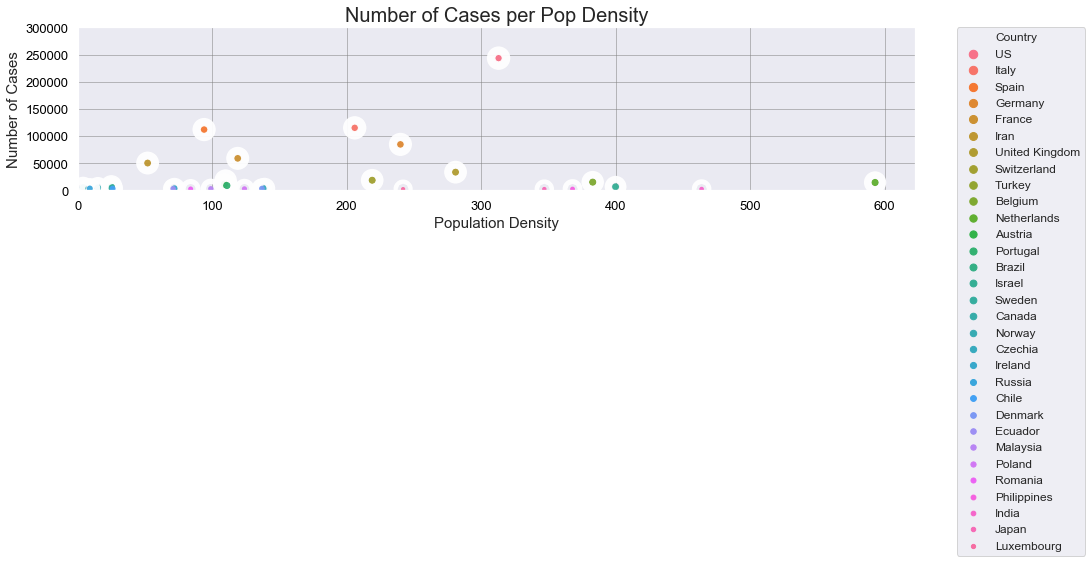

In [53]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.scatterplot("Pop_density", "4/2/20", data=Covid_global_data, hue="Country",linewidth=15, size= "Country", marker='o',
           alpha=0.95)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize=12)
#.set(xlim=(0, 600), ylim=(0, 200000), xticks=[100, 300, 600], yticks=[50000, 100000, 150000, 200000])

#plt.legend(fontsize='small', title_fontsize='3')

# control x and y limits
plt.ylim(0, 300000, 100000)
plt.xlim(0, None)

#Tick parameters
plt.tick_params(labelsize=13, direction='out', length=6, width=1, colors='black',
               grid_color='gray', grid_alpha=0.5)

#Title names
plt.title("Number of Cases per Pop Density", size=20)
plt.xlabel ('Population Density', size=15) 
plt.ylabel ('Number of Cases', size=15)
plt.grid(True)

plt.savefig('../figures/Fig-1_COVIDperPopDensity')


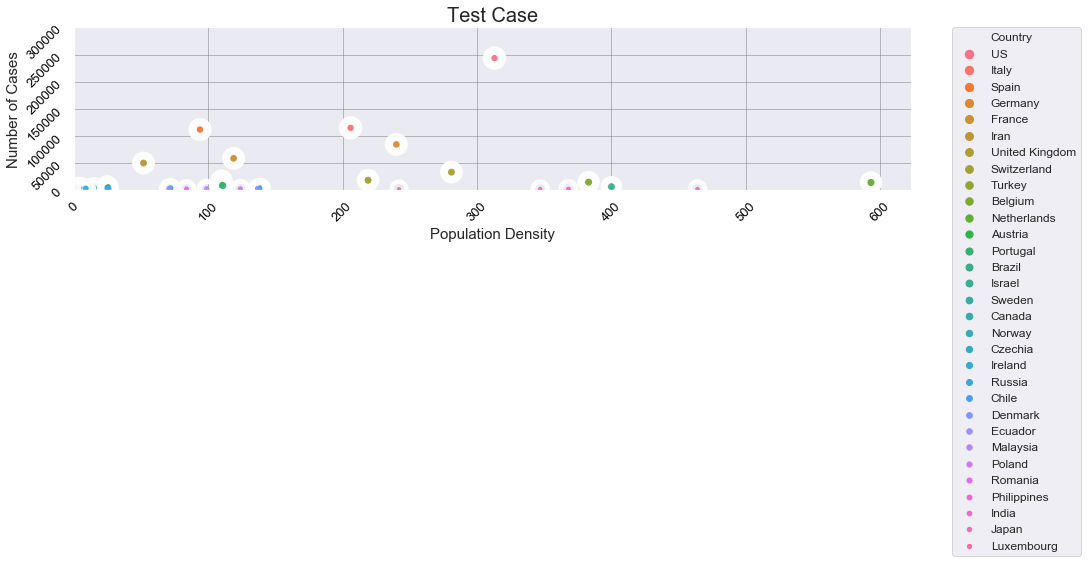

In [50]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.scatterplot("Pop_density", "4/2/20", data=Covid_global_data, hue="Country",linewidth=15, size= "Country", marker='o',
           alpha=0.95)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize=12)


# control x and y limits
plt.ylim(0, 300000, 100000)
plt.xlim(0, None)

#Tick parameters
plt.tick_params(labelsize=13, direction='out', labelrotation=45, length=6, width=1, colors='black',
               grid_color='gray', grid_alpha=0.5)

#Title names
plt.title("Test Case", size=20)
plt.xlabel ('Population Density', size=15) 
plt.ylabel ('Number of Cases', size=15)
plt.grid(True)

plt.savefig('../figures/Fig-2_TEST')

# Linear Regression (STUCK HERE)

In [24]:
#funciton to create linear regression plots
from scipy.stats import linregress
def plot_linear_regression(x_values, y_values, title, text_coordinates):
    
    #run regression on pop density vs COVID cases
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    #line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    line_eq = 'y = ' + str(round(slope,2)) + 'x + ' + str(round(intercept,2))
    
    #plot
    plt.scatter(x_values, y_values)
    plt.plot(x_values, regress_values, 'r-')
    plt.annotate(line_eq, text_coordinates, fontsize=15, color='red')
    plt.xlabel('Latitude')
    plt.ylabel(title)
    print(f'The r-squared is: {rvalue}')
    plt.show

In [25]:

#create north and south hemisphere dataFrames
pop_density = Covid_global_data.loc[(Covid_global_data['Pop_density'])]
current_cases = Covid_global_data.loc[(Covid_global_data["4/2/20"])]

x_values = pop_density['Pop_density']
y_values = current_cases['4/2/20']

plot_linear_regression(x_values, y_values, 'Pop_density',(6,30))

/Users/eli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


KeyError: "None of [Int64Index([243453, 115242, 112065,  84794,  59105,  50468,  33718,  18827,\n             18135,  15348,  14697,  11129,   9034,   8044,   6857,   5568,\n              5518,   5147,   3858,   3849,   3548,   3404,   3386,   3163,\n              3116,   2946,   2738,   2633,   2543,   2495,   2487],\n           dtype='int64')] are in the [index]"

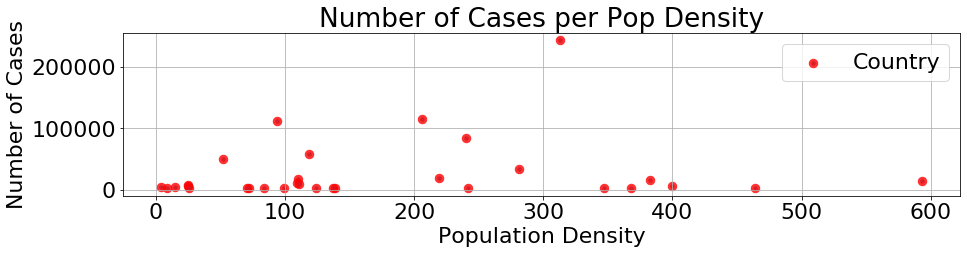

In [26]:
Covid_global_data.plot.scatter("Pop_density","4/2/20", edgecolor='red', linewidth=5, marker='o',
           alpha=0.8, label='Country')
#plt.scatter(covid_pivot)
#plt.legend(loc="upper left")

plt.title("Number of Cases per Pop Density" )
plt.xlabel ('Population Density') 
plt.ylabel ('Number of Cases')
plt.grid(True)

In [27]:
import seaborn as sns
sns.scatterplot("Pop_density", "Country", data=Covid_global_data, hue="Country",style="Country", linewidth=10, s=300, marker='o',
           alpha=0.3)

plt.title("Number of Cases per Pop Density" )
plt.xlabel ('Population Density') 
plt.ylabel ('Number of Cases')
plt.grid(True)

ValueError: These `style` levels are missing markers: {'Romania', 'India', 'Poland', 'Turkey', 'Brazil', 'Philippines', 'Belgium', 'Chile', 'Portugal', 'Israel', 'Ecuador', 'Malaysia', 'Denmark', 'Ireland', 'Netherlands', 'Canada', 'Czechia', 'Japan', 'Norway', 'Luxembourg', 'Sweden', 'Austria', 'Russia'}

NameError: name 'Country' is not defined

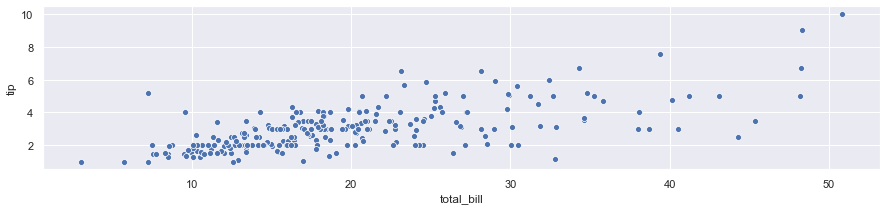

In [28]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

tips = sns.load_dataset("tips")
ax = sns.scatterplot(x="total_bill", y="tip", data=tips)

cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(x="Pop_density", y="4/2/20",
                     hue="Country", size="size",
                     sizes=(20, 200), palette=cmap,
                     legend="full", data=Country)


#Covid_global_data.plot
#Covid_global_data.plot.scatter("Pop_density","4/2/20",

In [ ]:
# Plot the world average as a line chart
pop_density, = plt.plot(Country, Pop_density, color="blue", label="Population Density" )

# Plot the unemployment values for a single country
covid_count, = plt.plot(pop_density, combined_unemployed_data.loc['USA',["2010","2011","2012","2013","2014"]], 
                       # color="green",label=combined_unemployed_data.loc['USA',"Country Name"])

# Create a legend for our chart
plt.legend(handles=[pop_density, country], loc="best")

# Show the chart
plt.show()

In [29]:
import seaborn as sns
sns.scatterplot("Pop_density", "4/2/20", data=Covid_global_data, hue="Country",style="Country" hue_norm="Country" ,size_norm= "Country", linewidth=10, s=90, marker='o',
           alpha=0.3)

plt.title("Number of Cases per Pop Density" )
plt.xlabel ('Population Density') 
plt.ylabel ('Number of Cases')
plt.grid(True)

SyntaxError: invalid syntax (<ipython-input-29-221c54213adf>, line 2)

In [30]:
#Build a bar graph for active cases vs. country
plt.scatter(Country, max_temps,
           edgecolor='black', linewidth=1, marker='o',
           alpha=0.8, label='Cities')

#Incorporate the other graph properties
#plt.title (f'City Latitude vs. Max Temperature ({time.strftime('%x')})') #may have issue here
plt.title("City Latitude vs. Max Temperature (%s)" % time.strftime("%x"))
plt.xlabel ('Latitude') 
plt.ylabel ('Max Temperature (F)')
plt.grid(True)

#save the figure
plt.savefig('output_data/Fig-1_Lat_vs_Temp')

NameError: name 'Country' is not defined

# US Cities Covid-19 Data
___


In [31]:
# Loading raw Covid-19 data for US cities

raw_US_data = pd.read_csv("../Resources/Covid19_US_cities.csv")

raw_US_data.head(10)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Latitude,Longitude,...,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.271000,-170.132000,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.444300,144.793700,...,32,37,45,51,55,56,58,69,77,82
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.097900,145.673900,...,0,0,0,0,0,0,0,2,6,6
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.220800,-66.590100,...,39,51,64,79,100,127,174,239,286,316
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.335800,-64.896300,...,17,17,17,19,22,0,0,30,30,30
5,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,1,4,6,6,6,6,6,7,8,10
6,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,4,4,5,5,10,15,18,19,20,24
7,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,0,0,0,0,0,0,0,0,0,0
8,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,0,0,0,0,0,0,2,3,3,4
9,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,0,1,2,4,5,5,5,5,5,6


In [32]:
# Extracting required columns 

Covid_US_data = raw_US_data[["City/State",
                             "Latitude","Longitude",
                             "1/22/20", "1/29/20","2/5/20","2/12/20",
                             "2/19/20", "2/26/20", "3/4/20", "3/11/20",
                             "3/18/20", "3/25/20", "4/2/20"
                            ]]


# Sorting the DataFrame by latest case count

Covid_US_data = Covid_US_data.sort_values("4/2/20", ascending = False)

Covid_US_data.head(60)

,City/State,Latitude,Longitude,1/22/20,1/29/20,2/5/20,2/12/20,2/19/20,2/26/20,3/4/20,3/11/20,3/18/20,3/25/20,4/2/20
1863,"New York City, New York, US",40.767273,-73.971526,0,0,0,0,0,0,1,55,1871,17856,51809
1892,"Westchester, New York, US",41.162784,-73.757417,0,0,0,0,0,0,10,121,538,4691,11567
1862,"Nassau, New York, US",40.740665,-73.589419,0,0,0,0,0,0,0,28,278,3285,10587
1884,"Suffolk, New York, US",40.883201,-72.801217,0,0,0,0,0,0,0,6,116,2260,8746
615,"Cook, Illinois, US",41.841448,-87.816588,0,1,2,2,2,2,4,22,178,1418,5575
1317,"Wayne, Michigan, US",42.280984,-83.281255,0,0,0,0,0,0,0,1,23,1122,5069
3231,"Unassigned, New Jersey, US",0.000000,0.000000,0,0,0,0,0,0,0,0,0,930,4866
1780,"Bergen, New Jersey, US",40.960109,-74.071643,0,0,0,0,0,0,0,11,114,819,4099
209,"Los Angeles, California, US",34.308284,-118.228241,0,1,1,1,1,1,7,27,190,812,4045
1876,"Rockland, New York, US",41.150279,-74.025605,0,0,0,0,0,0,0,6,31,968,3751


In [33]:
# Selecting one city per state

Covid_US_data = Covid_US_data.loc[[1863,615,1317,1780,209,1153,367,2974,1298,313,2299,1234,750,1753,
                                   108,2628,3092,451,1583,2065,324,2511,265,1954,1212,2799],:]

Covid_US_data.reset_index(inplace = True, drop = True)

Covid_US_data

,City/State,Latitude,Longitude,1/22/20,1/29/20,2/5/20,2/12/20,2/19/20,2/26/20,3/4/20,3/11/20,3/18/20,3/25/20,4/2/20
0,"New York City, New York, US",40.767273,-73.971526,0,0,0,0,0,0,1,55,1871,17856,51809
1,"Cook, Illinois, US",41.841448,-87.816588,0,1,2,2,2,2,4,22,178,1418,5575
2,"Wayne, Michigan, US",42.280984,-83.281255,0,0,0,0,0,0,0,1,23,1122,5069
3,"Bergen, New Jersey, US",40.960109,-74.071643,0,0,0,0,0,0,0,11,114,819,4099
4,"Los Angeles, California, US",34.308284,-118.228241,0,1,1,1,1,1,7,27,190,812,4045
5,"Orleans, Louisiana, US",30.069720,-89.926603,0,0,0,0,0,0,0,5,187,827,3148
6,"Miami-Dade, Florida, US",25.611236,-80.551706,0,0,0,0,0,0,0,0,76,400,2886
7,"King, Washington, US",47.491379,-121.834613,1,1,1,1,1,1,31,190,562,1359,2656
8,"Oakland, Michigan, US",42.660901,-83.385954,0,0,0,0,0,0,0,1,59,543,2183
9,"Fairfield, Connecticut, US",41.268099,-73.388117,0,0,0,0,0,0,0,2,69,546,2132


In [34]:
# Splitting City/State column in to separate City and State columns

city_states = Covid_US_data["City/State"]

cities = []
states = []

# Loop through City/State Column

for citystate in city_states:
    x = citystate.split(",",2)
    cities.append(x[0])
    states.append(x[1])

# Add cities to City Clumn & states to "State" column 

Covid_US_data["City"] = cities
Covid_US_data["State"] = states

Covid_US_data.head()

,City/State,Latitude,Longitude,1/22/20,1/29/20,2/5/20,2/12/20,2/19/20,2/26/20,3/4/20,3/11/20,3/18/20,3/25/20,4/2/20,City,State
0,"New York City, New York, US",40.767273,-73.971526,0,0,0,0,0,0,1,55,1871,17856,51809,New York City,New York
1,"Cook, Illinois, US",41.841448,-87.816588,0,1,2,2,2,2,4,22,178,1418,5575,Cook,Illinois
2,"Wayne, Michigan, US",42.280984,-83.281255,0,0,0,0,0,0,0,1,23,1122,5069,Wayne,Michigan
3,"Bergen, New Jersey, US",40.960109,-74.071643,0,0,0,0,0,0,0,11,114,819,4099,Bergen,New Jersey
4,"Los Angeles, California, US",34.308284,-118.228241,0,1,1,1,1,1,7,27,190,812,4045,Los Angeles,California


#### _Extracting temperatures for US cities_

In [35]:
# base url to extract temperatures

base_url = "http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID="

# Retrieving latitudes and longitudes

lats = Covid_US_data["Latitude"]
lngs = Covid_US_data["Longitude"]
lat_lngs = zip(lats, lngs)

# Create a list to store temperatures

temperatures = []

# Aquiring temperatures by making api calls

for lat_lng in lat_lngs:
    query_url = f'{base_url}{weather_key}&lat={lat_lng[0]}&lon={lat_lng[1]}'
    results = requests.get(query_url).json()
    country_temp = results["main"]["temp"]
    temperatures.append(country_temp)
    
# Add temperatures to "Temperature" column 

Covid_US_data["Temp(F)"] = temperatures


In [36]:
# Arrange the columns in the desired order
Covid_US_data = raw_US_data[["City/State",
                             "Latitude","Longitude",
                             "1/22/20", "1/29/20","2/5/20","2/12/20",
                             "2/19/20", "2/26/20", "3/4/20", "3/11/20",
                             "3/18/20", "3/25/20", "4/2/20"
                             
                            ]]


Covid_US_data




,City/State,Latitude,Longitude,1/22/20,1/29/20,2/5/20,2/12/20,2/19/20,2/26/20,3/4/20,3/11/20,3/18/20,3/25/20,4/2/20
0,"American Samoa, US",-14.2710,-170.1320,0,0,0,0,0,0,0,0,0,0,0
1,"Guam, US",13.4443,144.7937,0,0,0,0,0,0,0,0,5,37,82
2,"Northern Mariana Islands, US",15.0979,145.6739,0,0,0,0,0,0,0,0,0,0,6
3,"Puerto Rico, US",18.2208,-66.5901,0,0,0,0,0,0,0,0,5,51,316
4,"Virgin Islands, US",18.3358,-64.8963,0,0,0,0,0,0,0,0,2,17,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3248,"Unassigned, Washington, US",0.0000,0.0000,0,0,0,0,0,0,0,0,0,51,344
3249,"Unassigned, West Virginia, US",0.0000,0.0000,0,0,0,0,0,0,0,0,0,0,0
3250,"Unassigned, Wisconsin, US",0.0000,0.0000,0,0,0,0,0,0,0,0,0,0,0
3251,"Unassigned, Wyoming, US",0.0000,0.0000,0,0,0,0,0,0,0,0,0,0,0


#### _Extracting Population_density for US Cities_

In [37]:
# Splitting City/State column in to separate City and State columns
# hmm. trying to split city/state but requiest for .loc

city_state = Covid_US_data["City/State"]

city = []
state = []

# Loop through City/State Column

for citystates in city_state:
    x = citystates.split(",",2)
    city.append(x[0])
    state.append(x[1])

# Add cities to City column & states to "State" column 

Covid_US_data["City"] = city
Covid_US_data["State"] = state

/Users/eli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/eli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [38]:
# Loading raw data for population 
Population_US_City_data = pd.read_csv("../Resources/Population_US_Cities.csv")

# Renaming Column names
Population_US_City_data = Population_US_City_data.rename(columns={"2016 Population": "Population",
                                                                  "Population Density (Persons/Square Mile)": "Pop_density"
                                                                 })

# Dropping duplicate values
Population_US_City_data = Population_US_City_data.drop_duplicates(subset = 'City', keep='first')

# Resetting the index 
Population_US_City_data.reset_index(inplace = True, drop = True)

Population_US_City_data

,Index,City,State,Pop_density,Population,Land Area (Square Miles)
0,1,New York,New York,28211,8537673,303
1,2,Los Angeles,California,8484,3976322,469
2,3,Chicago,Illinois,11883,2704958,228
3,4,Houston,Texas,3842,2303482,600
4,5,Phoenix,Arizona,3126,1615017,517
...,...,...,...,...,...,...
710,749,Plainfield,New Jersey,8411,50636,6
711,750,Cerritos,California,5791,50555,9
712,751,Galveston,Texas,1226,50550,41
713,752,Coeur d'Alene,Idaho,3230,50285,16


In [39]:
Covid_US_data.columns

Index(['City/State', 'Latitude', 'Longitude', '1/22/20', '1/29/20', '2/5/20',
       '2/12/20', '2/19/20', '2/26/20', '3/4/20', '3/11/20', '3/18/20',
       '3/25/20', '4/2/20', 'City', 'State'],
      dtype='object')

In [40]:
# Merge Covid global data and population global data

Covid_US_data = pd.merge(Covid_US_data, Population_US_City_data, on = "City", how = 'left')

Covid_US_data

,City/State,Latitude,Longitude,1/22/20,1/29/20,2/5/20,2/12/20,2/19/20,2/26/20,3/4/20,...,3/18/20,3/25/20,4/2/20,City,State_x,Index,State_y,Pop_density,Population,Land Area (Square Miles)
0,"American Samoa, US",-14.2710,-170.1320,0,0,0,0,0,0,0,...,0,0,0,American Samoa,US,NaN,NaN,NaN,NaN,NaN
1,"Guam, US",13.4443,144.7937,0,0,0,0,0,0,0,...,5,37,82,Guam,US,NaN,NaN,NaN,NaN,NaN
2,"Northern Mariana Islands, US",15.0979,145.6739,0,0,0,0,0,0,0,...,0,0,6,Northern Mariana Islands,US,NaN,NaN,NaN,NaN,NaN
3,"Puerto Rico, US",18.2208,-66.5901,0,0,0,0,0,0,0,...,5,51,316,Puerto Rico,US,NaN,NaN,NaN,NaN,NaN
4,"Virgin Islands, US",18.3358,-64.8963,0,0,0,0,0,0,0,...,2,17,30,Virgin Islands,US,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3248,"Unassigned, Washington, US",0.0000,0.0000,0,0,0,0,0,0,0,...,0,51,344,Unassigned,Washington,NaN,NaN,NaN,NaN,NaN
3249,"Unassigned, West Virginia, US",0.0000,0.0000,0,0,0,0,0,0,0,...,0,0,0,Unassigned,West Virginia,NaN,NaN,NaN,NaN,NaN
3250,"Unassigned, Wisconsin, US",0.0000,0.0000,0,0,0,0,0,0,0,...,0,0,0,Unassigned,Wisconsin,NaN,NaN,NaN,NaN,NaN
3251,"Unassigned, Wyoming, US",0.0000,0.0000,0,0,0,0,0,0,0,...,0,0,0,Unassigned,Wyoming,NaN,NaN,NaN,NaN,NaN


In [41]:
Covid_US_data.columns

Index(['City/State', 'Latitude', 'Longitude', '1/22/20', '1/29/20', '2/5/20',
       '2/12/20', '2/19/20', '2/26/20', '3/4/20', '3/11/20', '3/18/20',
       '3/25/20', '4/2/20', 'City', 'State_x', 'Index', 'State_y',
       'Pop_density', 'Population', 'Land Area (Square Miles)'],
      dtype='object')

In [42]:

#Remove City/State


In [43]:
#Sort columns to desired configuration

In [44]:
raw_State_data = pd.read_csv("../Resources/Covid19_US_States.csv")

raw_State_data.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [ ]:
raw_State_data = raw_State_data.transpose()
raw_State_data

In [ ]:
#Merge all data together?
#US Cities + Temperature + Covid

In [ ]:
#US Cities + Temperature + Covid

In [ ]:
#Data plotting

In [ ]:
#Statistical analysis